# OAK Developers Tutorial

This tutorial is primarily for **Python Developers** who wish to use OAK in their applications. These include
applications such as:

- building ontology-driven data portals
- creating curation tools
- data science and machine learning applications
- web services

Some basic knowledge of the overall architecture and capabilities of OAK is assumed.

You may want to start with the slides on the command line here: https://doi.org/10.5281/zenodo.7708963

Or part 1 of the tutorial here: https://incatools.github.io/ontology-access-kit/intro/tutorial01.html

There is a video of the walkthrough of this tutorial: https://www.youtube.com/watch?v=nVTWazO_Gu0


## How to follow this tutorial

The easiest way to run this tutorial is to clone the repo and run locally:

1. clone the repo here https://github.com/INCATools/ontology-access-kit/
2. cd ontology-access-kit
3. poetry install
4. poetry run jupyter notebook

Alternatively, everything here should work on a fresh install of oak from pypi. You will need to make sure the test files from [tests/input](https://github.com/INCATools/ontology-access-kit/tree/main/tests/input) are accessible.

Some of the examples work with these test files - others will work with versions of ontologies on the web.

### Change directory so that test files are directly accessible

Note: this is necessary if you are running from a checkout of the OAK repo, since this notebook is in a subfolder

In [1]:
%cd ..

/Users/cjm/repos/ontology-access-kit


The OAK documentation makes heavy use of some of the unit test files in the [tests/input](https://github.com/INCATools/ontology-access-kit/tree/main/tests/input) folder.

This include a little mini test subset of GO, available in different formats for the purposes of testing different adapters:

In [2]:
!ls tests/input/go-nucleus.*

tests/input/go-nucleus.cx      tests/input/go-nucleus.ofn
tests/input/go-nucleus.db      tests/input/go-nucleus.owl
tests/input/go-nucleus.json    tests/input/go-nucleus.owl.ttl
tests/input/go-nucleus.obo


If you are an OAK core developer it helps to be aware of these files, as you will likely be writing new unit tests.

If one the other hand you just want to use OAK in your own code you don't need to know anything about these except that they are handy for quick testing.

## Running Examples from the OAK sphinx docs

The sphinx docs include code examples, these are visible from the `>>>`s

For example, in:

https://incatools.github.io/ontology-access-kit/packages/interfaces/basic

You can see sections like this:

![images/oak-docs-code.png](images/oak-docs-code.png)

If you click the "copy" button it will copy the code only (no `>>>`s, and no output) such that you
can paste directly into a Pythin REPL or a notebook (provided the paths are preserved).

E.g. try copying this section from the docs

```python
>>> from oaklib import get_adapter
>>> adapter = get_adapter('tests/input/go-nucleus.db')
>>> print(adapter.label("GO:0005634"))
```

In [4]:
from oaklib import get_adapter
adapter = get_adapter('tests/input/go-nucleus.db')
print(adapter.label("GO:0005634"))

nucleus


Hurray! All examples throughout the OAK docs should work

Note that you can play with using different input formats - this should give the same results:

In [6]:
from oaklib import get_adapter
adapter = get_adapter('tests/input/go-nucleus.obo')
print(adapter.label("GO:0005634"))

nucleus


## Working with whole ontologies

Almost all the examples in this tutorial make use of pre-made sqlite versions of ontologies.

These are specified using [selector](https://incatools.github.io/ontology-access-kit/packages/selectors.html) syntax:

```
sqlite:obo:ONTID
```

E.g.

```
sqlite:obo:cl
```

When you use this for the first time it will download and cache the file (using pystow), so there may be an initial lag

In [8]:
from oaklib import get_adapter
adapter = get_adapter("sqlite:obo:cl")
print(adapter.label("CL:0000540"))

neuron


Hurray! We successfully fetched the label (name) for a class ID in the cell ontology!

Note that the `label` method is part of the BasicOntologyInterface

### BasicOntologyInterface

The [BasicOntologyInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/basic) provides basic methods that encompass the majority of what most people need to do when
working with ontologies - lookups of various kinds as well as simple graph operations.

OAK has the architectural concept of separating interfaces from implementatations. It helps to read about this concept, but for now you don't need to worry about it. We are using the sql adapter which fully *implements* almost all the existing OAK interfaces

### Fetching ancestors

Next we are going to fetch ancestors. 

Note: it would help to review [tutorial part 1](https://incatools.github.io/ontology-access-kit/intro/tutorial01.html) to understand basic concepts of edges, ancestors, and predicates.

In [9]:
from oaklib.datamodels.vocabulary import IS_A
for anc in adapter.ancestors("CL:0000540", predicates=[IS_A]):
    print(anc, adapter.label(anc))

CL:0000540 neuron
BFO:0000002 continuant
BFO:0000004 independent continuant
BFO:0000040 material entity
CL:0000000 cell
CL:0000003 native cell
CL:0000211 electrically active cell
CL:0000255 eukaryotic cell
CL:0000393 electrically responsive cell
CL:0000404 electrically signaling cell
CL:0000540 neuron
CL:0000548 animal cell
CL:0002319 neural cell
CL:0002371 somatic cell


### Fetching descendants

Let's try working with descendants.

This time we are going to demonstate how OAK deals with collections.

__note__ _we expect the following code **not** to work_

In [10]:
neurons = adapter.descendants("CL:0000540", predicates=[IS_A])
try:
    print(len(neurons))
except(Exception) as e:
    print(f"PROBLEM: {e}")

PROBLEM: object of type 'generator' has no len()


Why didn't this work? What does `object of type 'generator' has no len()` mean?

To understand why we will mention a key concept in OAK, that of the iterator

### Iterators

OAK methods rarely return lists - instead they return iterators. This means that code is better adaptable to use cases
where you want to work with potentially very large lists or you want to *stream* results. See:

See [best practice](https://incatools.github.io/ontology-access-kit/packages/best-practice.html#iterators)

However, if you don't care about this you can simple use `list(...)` to get a list:

In [11]:
neurons = list(adapter.descendants("CL:0000540", predicates=[IS_A]))
print(len(neurons))

454


You can also cast to `set()` to use set operations like intersections.

For example, let's say we want to compose our neuron query above with a query to fetch all things in the forebrain,
to get all neurons in the forebrain:

In [12]:
from oaklib.datamodels.vocabulary import IS_A, PART_OF
parts_of_forebrain = set(adapter.descendants("UBERON:0001890", predicates=[IS_A, PART_OF]))
print(len(parts_of_forebrain))

219


You may be wondering what Uberon terms are doing here given that we requested the cell ontology in `get_adapter`

One under-appreciated fact of OBO is that many ontologies are in fact mini "knowledge graphs", linking out to nodes in other ontologies. See 

 - [extracting using robot](https://oboacademy.github.io/obook/tutorial/robot-tutorial-1/) (OBO Academy)
 - [owl format variants](https://oboacademy.github.io/obook/explanation/owl-format-variants/) (OBO Academy)
 - [OAK basics](https://incatools.github.io/ontology-access-kit/guide/basics.html) (OAK Guide)
 
 
 OK next lets do an **intersection** between the two lists

In [13]:
for cell in parts_of_forebrain.intersection(neurons):
    print(cell, adapter.label(cell))

CL:1001435 periglomerular cell
CL:4023040 L2/3-6 intratelencephalic projecting glutamatergic cortical neuron
CL:1001571 hippocampal pyramidal neuron
CL:1001502 mitral cell
CL:1001434 olfactory bulb interneuron
CL:4023048 L4/5 intratelencephalic projecting glutamatergic neuron of the primary motor cortex
CL:1001505 parvocellular neurosecretory cell
CL:4023008 intratelencephalic-projecting glutamatergic cortical neuron
CL:4023049 L5 intratelencephalic projecting glutamatergic neuron of the primary motor cortex
CL:4023047 L2/3 intratelencephalic projecting glutamatergic neuron of the primary motor cortex
CL:4023081 inverted L6 intratelencephalic projecting glutamatergic neuron of the primary motor cortex (Mmus)
CL:4023050 L6 intratelencephalic projecting glutamatergic neuron of the primary motor cortex
CL:1001503 olfactory bulb tufted cell
CL:4023080 stellate L6 intratelencephalic projecting glutamatergic neuron of the primary motor cortex (Mmus)


This is **all the neurons that are part of the forebrain**.

Readers familiar with OWL and Protege may like to think of this as similar to a DL query for the expression `neuron and part-of some forebrain` -- there are some theoretical differences we won't get into here but for practical purposes the results should be the same.

### Relationships

The above example uses the ancestors and descendants query in [BasicOntologyInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/basic).

We can also get the relationships using the `relationships` method:

In [15]:
for rel in adapter.relationships(["CL:0000540"]):
    print(rel)

('CL:0000540', 'RO:0002215', 'GO:0019226')
('CL:0000540', 'rdfs:subClassOf', 'BFO:0000040')
('CL:0000540', 'rdfs:subClassOf', 'CL:0000393')
('CL:0000540', 'rdfs:subClassOf', 'CL:0000404')
('CL:0000540', 'rdfs:subClassOf', 'CL:0002319')


In [17]:
for _s, p, o in adapter.relationships(["CL:0000540"]):
    print(f" {p} {adapter.label(p)} {o} {adapter.label(o)}")

 RO:0002215 capable of GO:0019226 transmission of nerve impulse
 rdfs:subClassOf None BFO:0000040 material entity
 rdfs:subClassOf None CL:0000393 electrically responsive cell
 rdfs:subClassOf None CL:0000404 electrically signaling cell
 rdfs:subClassOf None CL:0002319 neural cell


In [18]:
for s, p, _o in list(adapter.relationships(objects=["CL:0000540"]))[0:10]:
    print(f" {p} FROM: {s} {adapter.label(s)}")

 rdfs:subClassOf FROM: CL:0000028 CNS neuron (sensu Nematoda and Protostomia)
 rdfs:subClassOf FROM: CL:0000029 neural crest derived neuron
 rdfs:subClassOf FROM: CL:0000099 interneuron
 rdfs:subClassOf FROM: CL:0000102 polymodal neuron
 rdfs:subClassOf FROM: CL:0000104 multipolar neuron
 rdfs:subClassOf FROM: CL:0000105 pseudounipolar neuron
 rdfs:subClassOf FROM: CL:0000106 unipolar neuron
 rdfs:subClassOf FROM: CL:0000108 cholinergic neuron
 rdfs:subClassOf FROM: CL:0000109 adrenergic neuron
 rdfs:subClassOf FROM: CL:0000110 peptidergic neuron


In [14]:
for _s, _p, o in adapter.relationships(["CL:0000540"], predicates=[PART_OF], include_entailed=True):
    print(o, adapter.label(o))

BFO:0000002 continuant
BFO:0000004 independent continuant
BFO:0000040 material entity
CARO:0000000 anatomical entity
CARO:0000006 material anatomical entity
CARO:0030000 biological entity
UBERON:0000061 anatomical structure
UBERON:0000465 material anatomical entity
UBERON:0000467 anatomical system
UBERON:0000468 multicellular organism
UBERON:0001016 nervous system
UBERON:0001062 anatomical entity
UBERON:0010000 multicellular anatomical structure


This includes all the entailed part-of relationships from neuron, including trivial ones ("every neuron is part of a material entity")

In [19]:
for s, _p, o in list(adapter.relationships(objects=["CL:0000540"], predicates=[IS_A], include_entailed=True))[0:10]:
    print(s, adapter.label(s))

CL:0000705 R6 photoreceptor cell
CL:4023108 oxytocin-secreting magnocellular cell
CL:0004240 WF1 amacrine cell
CL:0004242 WF3-1 amacrine cell
CL:1000380 type 1 vestibular sensory cell of epithelium of macula of saccule of membranous labyrinth
CL:1001582 lateral ventricle neuron
CL:4023128 rostral periventricular region of the third ventricle KDNy neuron
CL:0003020 retinal ganglion cell C outer
CL:4023094 tufted pyramidal neuron
CL:4023057 cerebellar inhibitory GABAergic interneuron


### Creating a Data Frame for Relationships

Next we will see how to create a small data frame for relationships for forebrain neurons:

In [20]:
import pandas as pd

forebrain_neurons = parts_of_forebrain.intersection(neurons)

objs = []
for s, p, o in adapter.relationships(forebrain_neurons):
    objs.append({"s": s, "s_label": adapter.label(s), 
                 "p": p, "p_label": adapter.label(p),
                 "o": o, "o_label": adapter.label(o)})

df = pd.DataFrame(objs)
df

s                                            s_label  \
0   CL:1001434                         olfactory bulb interneuron   
1   CL:1001434                         olfactory bulb interneuron   
2   CL:1001434                         olfactory bulb interneuron   
3   CL:1001434                         olfactory bulb interneuron   
4   CL:1001434                         olfactory bulb interneuron   
5   CL:1001435                                periglomerular cell   
6   CL:1001435                                periglomerular cell   
7   CL:1001502                                        mitral cell   
8   CL:1001502                                        mitral cell   
9   CL:1001503                         olfactory bulb tufted cell   
10  CL:1001503                         olfactory bulb tufted cell   
11  CL:1001503                         olfactory bulb tufted cell   
12  CL:1001505                  parvocellular neurosecretory cell   
13  CL:1001505                  parvocellular neurosecretory cell   
14  CL:1001505                  parvocellular neurosecretory cell   
15  CL:1001505                  parvocellular neurosecretory cell   
16  CL:1001505                  parvocellular neurosecretory cell   
17  CL:1001505                  parvocellular neurosecretory cell   
18  CL:1001571                       hippocampal pyramidal neuron   
19  CL:1001571                       hippocampal pyramidal neuron   
20  CL:1001571                       hippocampal pyramidal neuron   
21  CL:4023008  intratelencephalic-projecting glutamatergic co...   
22  CL:4023008  intratelencephalic-projecting glutamatergic co...   
23  CL:4023008  intratelencephalic-projecting glutamatergic co...   
24  CL:4023040  L2/3-6 intratelencephalic projecting glutamate...   
25  CL:4023047  L2/3 intratelencephalic projecting glutamaterg...   
26  CL:4023047  L2/3 intratelencephalic projecting glutamaterg...   
27  CL:4023047  L2/3 intratelencephalic projecting glutamaterg...   
28  CL:4023048  L4/5 intratelencephalic projecting glutamaterg...   
29  CL:4023048  L4/5 intratelencephalic projecting glutamaterg...   
30  CL:4023048  L4/5 intratelencephalic projecting glutamaterg...   
31  CL:4023049  L5 intratelencephalic projecting glutamatergic...   
32  CL:4023049  L5 intratelencephalic projecting glutamatergic...   
33  CL:4023049  L5 intratelencephalic projecting glutamatergic...   
34  CL:4023050  L6 intratelencephalic projecting glutamatergic...   
35  CL:4023050  L6 intratelencephalic projecting glutamatergic...   
36  CL:4023050  L6 intratelencephalic projecting glutamatergic...   
37  CL:4023050  L6 intratelencephalic projecting glutamatergic...   
38  CL:4023080  stellate L6 intratelencephalic projecting glut...   
39  CL:4023080  stellate L6 intratelencephalic projecting glut...   
40  CL:4023081  inverted L6 intratelencephalic projecting glut...   
41  CL:4023081  inverted L6 intratelencephalic projecting glut...   

                  p            p_label               o  \
0       BFO:0000050            part of  UBERON:0002264   
1        RO:0002100  has soma location  UBERON:0002264   
2   rdfs:subClassOf               None      CL:0000101   
3   rdfs:subClassOf               None      CL:0000402   
4   rdfs:subClassOf               None      CL:0012001   
5        RO:0002100  has soma location  UBERON:0005377   
6   rdfs:subClassOf               None      CL:1001434   
7        RO:0002100  has soma location  UBERON:0004186   
8   rdfs:subClassOf               None      CL:1001434   
9       BFO:0000050            part of  UBERON:0005376   
10  rdfs:subClassOf               None    CARO:0000000   
11  rdfs:subClassOf               None      CL:0000540   
12      BFO:0000050            part of  UBERON:0001930   
13       RO:0002215         capable of      GO:0030103   
14  rdfs:subClassOf               None    CARO:0000000   
15  rdfs:subClassOf               None      CL:0000167   
16  rdfs:subClassOf               None      CL:0000381   
1

### Aliases

The BasicOntologyInterface has a deliberately simple datamodel for aliases that can be expressed by returning
simple strings and tuples. Later on we can see how to leverage the more advanced OBO Graphs data model

In [21]:
adapter.entity_aliases("CL:0000540")

['nerve cell', 'neuron']

In [22]:
for pred, alias in adapter.alias_relationships("CL:0000540"):
    print(pred, alias)

rdfs:label neuron
oio:hasExactSynonym nerve cell


### Mappings

Similar to aliases, the BasicOntologyInterface has a very simple model of mappings. Later on we will see how we
can use the MappingProviderInterface to get more granular information.

In [25]:
for pred, xref in adapter.simple_mappings_by_curie("CL:0000202"):
    print(pred, xref)

oio:hasDbXref FMA:62364


## Subsets

See [Subsets](https://incatools.github.io/ontology-access-kit/glossary.html#term-Subset) in the OAK Glossary.

Subsets allow terms to be placed into groups outside the hierarchy for different purposes.

To illustrate we will switch our example to use GO which has a rich variety of subsets

In [26]:
go_adapter = get_adapter("sqlite:obo:go")

In [27]:
for subset in go_adapter.subsets():
    print(subset)

chebi_ph7_3
3_STAR
1_STAR
goslim_plant
goslim_pir
goslim_flybase_ribbon
goslim_chembl
goslim_agr
goslim_metagenomics
goslim_yeast
goslim_pombe
gocheck_do_not_annotate
goslim_generic
goslim_drosophila
goslim_candida
prokaryote_subset
gocheck_do_not_manually_annotate
goslim_synapse
goslim_mouse
SOFA
Alliance_of_Genome_Resources
biosapiens


note this includes subsets for ontologies that have been merged in

In [28]:
for e in list(go_adapter.subset_members("goslim_generic"))[0:10]:
    print(e, go_adapter.label(e))

GO:0000228 nuclear chromosome
GO:0000278 mitotic cell cycle
GO:0000910 cytokinesis
GO:0001618 virus receptor activity
GO:0002181 cytoplasmic translation
GO:0002376 immune system process
GO:0003012 muscle system process
GO:0003013 circulatory system process
GO:0003014 renal system process
GO:0003016 respiratory system process


### Plotting how GO subsets inter-relate

Now we are ready for a simple mini application - showing commonalities between 

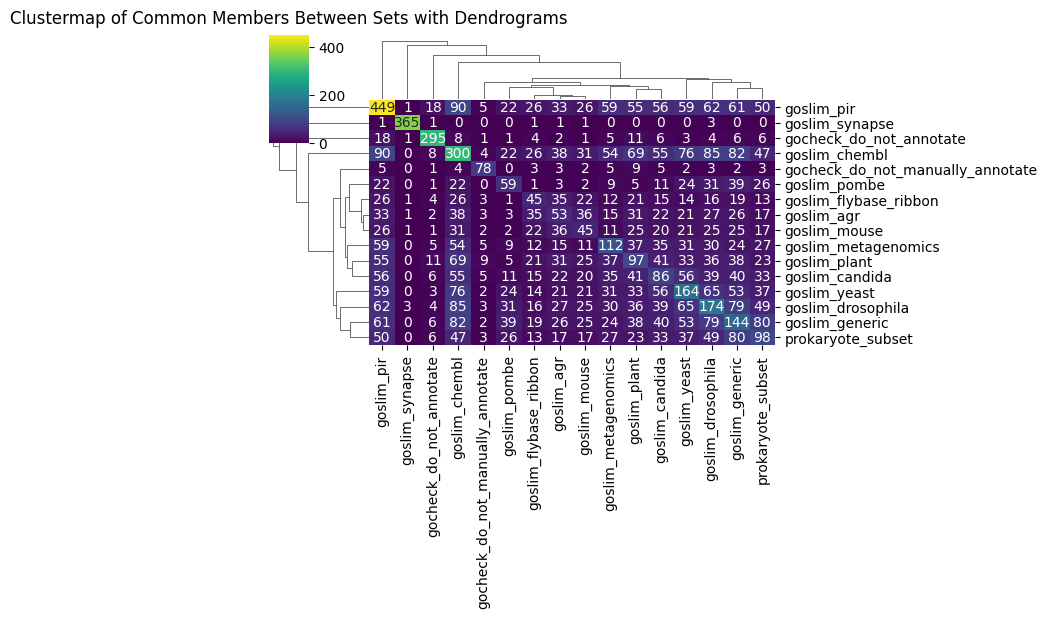

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sets = []

for subset in go_adapter.subsets():
    members = set([x for x in go_adapter.subset_members(subset) if x.startswith("GO:")])
    if members:
        sets.append((subset, members))


# Number of sets
N = len(sets)

# Initialize an empty matrix to store the number of members in common
intersection_matrix = np.zeros((N, N))

# Calculate the intersections between each pair of sets
for i in range(N):
    for j in range(N):
        intersection_matrix[i, j] = len(sets[i][1].intersection(sets[j][1]))

# Get the set names
set_names = [s[0] for s in sets]

# Create a pandas DataFrame with the intersection matrix and set names as index and columns
intersection_df = pd.DataFrame(intersection_matrix, index=set_names, columns=set_names)

# Plot the clustermap with dendrograms
sns.clustermap(intersection_df, annot=True, cmap='viridis', fmt='g', figsize=(8, 6))
plt.title('Clustermap of Common Members Between Sets with Dendrograms', y=1.03)
plt.show()


## Search Interface

So far we have been doing basic lookup information, assuming we know the ID in advance.

What if we don't know the ID but just have a label, or if we don't even have a particular concept in mind, and just want to search?

If so, the [SearchInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/search.html) is your friend!

### Lookup by label

In [30]:
for result in adapter.basic_search("neuron"):
    print(result)

CL:0000540


now let's try searching for the capitalized form:

In [31]:
len(list(adapter.basic_search("Neuron")))

0

uh oh!

By design, the default is case sensitive. But we can pass a SearchConfiguration to make search more customizable.

You can read more about the SearchConfiguration datamodel here:

- https://w3id.org/oak/search

__a note on data models__ the BasicOntologyInterface is designed to work without any particular data model, returning only simple lists and tuples. Other interfaces typically need to work with more sophisticated structures, so we use data models here.

In [32]:
from oaklib.datamodels.search import SearchConfiguration, SearchTermSyntax, SearchProperty

In [33]:
config = SearchConfiguration(force_case_insensitive=True)

In [34]:
len(list(adapter.basic_search("Neuron", config)))

1

In [35]:
len(list(adapter.basic_search("NeUrOn", config)))

1

We can also do regexes, starts-with, ends with etc (but see below for caveat)

In [37]:
config = SearchConfiguration(syntax=SearchTermSyntax.STARTS_WITH)

In [38]:
for result in adapter.basic_search("neuron", config):
    print(result, adapter.label(result))

CARO:0001001 neuron projection bundle
CL:0000006 neuronal receptor cell
CL:0000095 neuron associated cell
CL:0000123 neuron associated cell (sensu Vertebrata)
CL:0000130 neuron associated cell (sensu Nematoda and Protostomia)
CL:0000540 neuron
CL:0000555 neuronal brush cell
CL:0002611 neuron of the dorsal spinal cord
CL:0002612 neuron of the ventral spinal cord
CL:0002614 neuron of the substantia nigra
CL:0012001 neuron of the forebrain
GO:0001764 neuron migration
GO:0019228 neuronal action potential
GO:0030182 neuron differentiation
GO:0031175 neuron projection development
GO:0032589 neuron projection membrane
GO:0042551 neuron maturation
GO:0043005 neuron projection
GO:0043025 neuronal cell body
GO:0044306 neuron projection terminus
GO:0048666 neuron development
GO:0048812 neuron projection morphogenesis
GO:0051402 neuron apoptotic process
GO:0060705 neuron differentiation involved in salivary gland development
GO:0070050 neuron cellular homeostasis
GO:0070997 neuron death
GO:0106027

now we can try a regex:

In [39]:
config = SearchConfiguration(syntax=SearchTermSyntax.REGULAR_EXPRESSION)
for result in adapter.basic_search("^neuron", config):
    print(result, adapter.label(result))

CARO:0001001 neuron projection bundle
CL:0000006 neuronal receptor cell
CL:0000095 neuron associated cell
CL:0000123 neuron associated cell (sensu Vertebrata)
CL:0000130 neuron associated cell (sensu Nematoda and Protostomia)
CL:0000540 neuron
CL:0000555 neuronal brush cell
CL:0002611 neuron of the dorsal spinal cord
CL:0002612 neuron of the ventral spinal cord
CL:0002614 neuron of the substantia nigra
CL:0012001 neuron of the forebrain
GO:0001764 neuron migration
GO:0019228 neuronal action potential
GO:0030182 neuron differentiation
GO:0031175 neuron projection development
GO:0032589 neuron projection membrane
GO:0042551 neuron maturation
GO:0043005 neuron projection
GO:0043025 neuronal cell body
GO:0044306 neuron projection terminus
GO:0048666 neuron development
GO:0048812 neuron projection morphogenesis
GO:0051402 neuron apoptotic process
GO:0060705 neuron differentiation involved in salivary gland development
GO:0070050 neuron cellular homeostasis
GO:0070997 neuron death
GO:0106027

### Caveat on regexes

If your adapter is talking to sqlite, then the regex must be of a form that can be translated to a LIKE query

(OAK takes care of this translation - as a developer you should only care about the interface, not implementation)

In future we may have strategies to allow more powerful lexical search with sqlite...

### Searching on mapped identifiers

You can search on arbitrary properties, such as synonyms or even mapped identifiers (`object_id` in SSSOM lingo)

In [40]:
config = SearchConfiguration(properties=[SearchProperty.MAPPED_IDENTIFIER])
for result in adapter.basic_search("FMA:62364", config):
    print(result, adapter.label(result))

CL:0000202 auditory hair cell
CL:4023120 cochlea auditory hair cell


### SSSOM Mappings

Up above we saw that the default datamodel for mappings in OAK is simple. For more advanced operations, you can use:

[MappingProviderInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/mapping-provider.html)

This makes use of the https://w3id.org/sssom data model

In [41]:
neurons = list(adapter.descendants("CL:0000540", predicates=[IS_A]))
mappings = list(adapter.sssom_mappings(neurons))

In [42]:
len(mappings)

186

In [43]:
print(mappings[0])

Mapping(subject_id='CL:0000099', predicate_id='oio:hasDbXref', object_id='BTO:0003811', mapping_justification='semapv:UnspecifiedMatching', subject_label=None, subject_category=None, predicate_label=None, predicate_modifier=None, object_label=None, object_category=None, author_id=[], author_label=[], reviewer_id=[], reviewer_label=[], creator_id=[], creator_label=[], license=None, subject_type=None, subject_source='CL', subject_source_version=None, object_type=None, object_source='BTO', object_source_version=None, mapping_provider=None, mapping_source=None, mapping_cardinality=None, mapping_tool=None, mapping_tool_version=None, mapping_date=None, confidence=None, curation_rule=[], curation_rule_text=[], subject_match_field=[], object_match_field=[], match_string=[], subject_preprocessing=[], object_preprocessing=[], semantic_similarity_score=None, semantic_similarity_measure=None, see_also=[], other=None, comment=None)


In [44]:
from linkml_runtime.dumpers import yaml_dumper

In [45]:
print(yaml_dumper.dumps(mappings[0:2]))

- subject_id: CL:0000099
  predicate_id: oio:hasDbXref
  object_id: BTO:0003811
  mapping_justification: semapv:UnspecifiedMatching
  subject_source: CL
  object_source: BTO
- subject_id: CL:0000099
  predicate_id: oio:hasDbXref
  object_id: FBbt:00005125
  mapping_justification: semapv:UnspecifiedMatching
  subject_source: CL
  object_source: FBbt



## Text Annotation

Interface: [TextAnnotatorInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/text-annotator.html)

The text annotator uses the https://w3id.org/linkml/text-annotator data model. This models each annotation as an TextAnnotation object with fields such as subject_start and subject_end (marking the span in the text) and object_id and object_label (the matched concept):

In [46]:
for ann in adapter.annotate_text("this is a goblet cell from the intestinal epithelium"):
    print(ann.subject_start, ann.subject_end, ann.object_id, ann.object_label)

18 21 CARO:0000013 cell
18 21 CL:0000000 cell
9 9 CHEBI:15339 A
11 11 CHEBI:15428 G
18 18 CHEBI:27594 C
11 21 CL:0000160 goblet cell
1 2 PR:000016301 TH
1 2 PR:P07101 TH
1 2 PR:P24529 Th
1 2 UBERON:0001897 Th
43 52 UBERON:0000483 epithelium
32 52 UBERON:0001277 intestinal epithelium


### OBO Graph Interface

[OboGraphInterface](https://incatools.github.io/ontology-access-kit/packages/interfaces/obograph.html)

In [47]:
graph = adapter.ancestor_graph(["CL:0000540"], predicates=[IS_A, PART_OF])

In [48]:
len(graph.nodes)

25

In [49]:
len(graph.edges)

29

### Exporting subgraphs to GraphViz

See also [part 5](https://incatools.github.io/ontology-access-kit/intro/tutorial05.html) of the tutorial

In [50]:
from oaklib.utilities.obograph_utils import graph_to_image

In [51]:
graph_to_image(graph, seeds=["CL:0000540"], imgfile="notebooks/output/neuron-v1.png")

![img](output/neuron-v1.png)

### Adding a stylesheet

The graph above is a little plain and boring looking. We can spice it up using a StyleMap.

For now we will use the standard stylemap in [src/oaklib/conf/obograph-style.json](https://github.com/INCATools/ontology-access-kit/blob/main/src/oaklib/conf/obograph-style.json):

In [52]:
from oaklib.utilities.obograph_utils import default_stylemap_path

In [53]:
graph_to_image(graph, seeds=["CL:0000540"], imgfile="notebooks/output/neuron-v2.png", stylemap=default_stylemap_path())

![img](output/neuron-v2.png)

## Working with annotations

In [54]:
hp = get_adapter("src/oaklib/conf/hpoa-g2p-input-spec.yaml")

In [55]:
len(list(hp.associations()))

238269

In [56]:
for assoc in list(hp.associations())[0:15]:
    print(assoc, hp.label(assoc.object))

Association(subject='NCBIGene:ncbi_gene_id', predicate=None, object='hpo_id', property_values=[]) None
Association(subject='NCBIGene:10', predicate=None, object='HP:0000007', property_values=[]) Autosomal recessive inheritance
Association(subject='NCBIGene:10', predicate=None, object='HP:0001939', property_values=[]) Abnormality of metabolism/homeostasis
Association(subject='NCBIGene:16', predicate=None, object='HP:0002460', property_values=[]) Distal muscle weakness
Association(subject='NCBIGene:16', predicate=None, object='HP:0002451', property_values=[]) Limb dystonia
Association(subject='NCBIGene:16', predicate=None, object='HP:0010871', property_values=[]) Sensory ataxia
Association(subject='NCBIGene:16', predicate=None, object='HP:0009886', property_values=[]) Trichorrhexis nodosa
Association(subject='NCBIGene:16', predicate=None, object='HP:0002421', property_values=[]) Poor head control
Association(subject='NCBIGene:16', predicate=None, object='HP:0001298', property_values=[]) 

In [58]:
# Fetch sensory ataxia genes (including those annotated to is-a descendants of the term)
ataxia_assocs = list(hp.associations(objects=["HP:0010871"], object_closure_predicates=[IS_A]))
len(ataxia_assocs)

15

In [59]:
genes = list(set([assoc.subject for assoc in ataxia_assocs]))
len(genes)

15

In [60]:
genes[0:5]

['NCBIGene:56652',
 'NCBIGene:5428',
 'NCBIGene:16',
 'NCBIGene:1959',
 'NCBIGene:57716']

In [61]:
node_normalizer = get_adapter("translator:")
uniprot_ids = set()
for gene in genes:
    for m in node_normalizer.sssom_mappings([gene], source="UniProtKB"):
        uniprot_ids.add(m.object_id)
uniprot_ids

{'UniProtKB:A0A024RDV7',
 'UniProtKB:A0A140VJE4',
 'UniProtKB:A0A2R8Y4V4',
 'UniProtKB:A0A2R8Y746',
 'UniProtKB:A0A2U3TZU2',
 'UniProtKB:A0A514TP98',
 'UniProtKB:A0A5F9ZI26',
 'UniProtKB:A0A8I5KYI5',
 'UniProtKB:A8KA82',
 'UniProtKB:A8MU75',
 'UniProtKB:B2RB38',
 'UniProtKB:B4DE36',
 'UniProtKB:E5KNU5',
 'UniProtKB:E5KSY5',
 'UniProtKB:O00505',
 'UniProtKB:P06744',
 'UniProtKB:P11161',
 'UniProtKB:P25189',
 'UniProtKB:P49588',
 'UniProtKB:P54098',
 'UniProtKB:P54802',
 'UniProtKB:Q01453',
 'UniProtKB:Q13217',
 'UniProtKB:Q6FH25',
 'UniProtKB:Q8TF17',
 'UniProtKB:Q96K19',
 'UniProtKB:Q96RR1',
 'UniProtKB:Q9BXM0',
 'UniProtKB:Q9H5I5',
 'UniProtKB:Q9H6V3',
 'UniProtKB:Q9Y5Y0'}

In [63]:
go = get_adapter("src/oaklib/conf/go-human-input-spec.yaml")

In [64]:
results = list(go.enriched_classes(uniprot_ids, object_closure_predicates=[IS_A, PART_OF], autolabel=True))

In [66]:
for result in results:
    print(f"{result.class_id} '{result.class_label}' {result.p_value_adjusted:0.2e}")

GO:0042552 'myelination' 9.72e-04
GO:0008366 'axon ensheathment' 1.06e-03
GO:0007272 'ensheathment of neurons' 1.06e-03
GO:0007422 'peripheral nervous system development' 6.38e-03
GO:0014037 'Schwann cell differentiation' 2.75e-02


In [67]:
terms = [r.class_id for r in results]
graph = go.ancestor_graph(terms, predicates=[IS_A, PART_OF])

In [68]:
graph_to_image(graph, seeds=terms, imgfile="notebooks/output/go-enrichment-from-hp.png", stylemap=default_stylemap_path())

![img](output/go-enrichment-from-hp.png)